In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [4]:
# structures_to_sample = all_known_structures

# negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# margins_to_sample = [500] # (200: 100 um, 500: 250 um)
# surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
#                              for m in margins_to_sample
#                              for s in structures_to_sample 
#                              for surr_l in structures_to_sample + ['noclass'] 
#                              if surr_l != s]

# labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Train Classifiers

In [5]:
classifier_settings

,model,margin,train_set_id,neg_composition,sample_weighting
classifier_id,,,,,
30,lr,500,20/21,neg_has_all_surround,NaN
31,lr,500,21/22,neg_has_all_surround,NaN
32,lr,500,20/22,neg_has_all_surround,NaN
33,gb1,500,20/21,neg_has_all_surround,NaN
34,gb1,500,21/22,neg_has_all_surround,NaN
35,gb1,500,20/22,neg_has_all_surround,NaN
95,gb2,500,93,neg_has_all_surround,NaN
96,gb2,500,95,neg_has_all_surround,NaN
97,gb2,500,97,neg_has_all_surround,NaN


In [6]:
classifier_id = 95
classifier_properties = classifier_settings.loc[classifier_id]

margin = classifier_properties['margin']
model = classifier_properties['model']
sample_weighting = classifier_properties['sample_weighting']
neg_composition = classifier_properties['neg_composition']

In [7]:
# Determine which labels to load.

structures_to_sample = all_known_structures
negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [margin] # (200: 100 um, 500: 250 um)
surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample
                             if surr_l != s]
surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                             for m in margins_to_sample
                             for s in structures_to_sample]

if neg_composition == 'neg_has_everything_else':
    labels_to_sample = structures_to_sample + negative_labels_to_sample
elif neg_composition == 'neg_has_only_surround_noclass':
    labels_to_sample = structures_to_sample + surround_noclass_labels_to_sample + ['noclass']
elif neg_composition == 'neg_has_all_surround':
    labels_to_sample = structures_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample + ['noclass']

In [8]:
# Load training dataset.

training_set_ids = map(int, str(classifier_properties['train_set_id']).split('/'))
# training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample)
training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample, 
                                                      clf_rootdir=CELL_FEATURES_CLF_ROOTDIR)
    
assert set(training_addresses.keys()) == set(training_features.keys()), \
    'Training features and training addresses are not consistent.'

In [9]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found 
                        if convert_to_original_name(l) in labels_found]) - {'noclass'}

In [10]:
# setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % classifier_id))
setting_dir = os.path.join(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'setting_%d' % classifier_id))

In [11]:
clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('neg_composition %s is not recognized.' % neg_composition)

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
#     if setting == 9:
    if sample_weighting == 'weighted':
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
#     if setting in [1, 2, 8, 9, 10, 11, 23, 24]:
    if model == 'lr':
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
#     elif setting == 3:
    elif model == 'lin_svc':
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

#     elif setting == 4:
    elif model == 'lin_svc_calib':
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
#     elif setting in [5]:        
    elif model == 'xgb1':
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#     elif setting in [6, 25]:
    elif model == 'gb1':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
#     elif setting in [7, 26]:     
    elif model == 'gb2':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('Setting is not recognized.\n')

    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    clf_fp = os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=classifier_id))
    
    joblib.dump(clf, clf_fp)
    
    upload_to_s3(clf_fp)

Tz
      Iter       Train Loss   Remaining Time 
         1           1.2623            0.29s
         2           1.1865            0.29s
         3           1.1251            0.30s
         4           1.0782            0.30s
         5           1.0361            0.30s
         6           1.0137            0.29s
         7           0.9883            0.29s
         8           0.9596            0.29s
         9           0.9441            0.28s
        10           0.9240            0.28s
        20           0.8004            0.23s
        30           0.7053            0.20s
        40           0.6201            0.17s
        50           0.5720            0.14s
        60           0.5184            0.11s
        70           0.4747            0.08s
        80           0.4357            0.05s
        90           0.3962            0.03s
       100           0.3644            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/Tz_clf_setting_95.dump s3://m

Fitting classifier: 0.27 seconds
Child returned 0
0.42 seconds.


Sp5O
      Iter       Train Loss   Remaining Time 
         1           1.2166            0.32s
         2           1.1788            0.33s
         3           1.1462            0.34s
         4           1.1141            0.34s
         5           1.0894            0.34s
         6           1.0648            0.33s
         7           1.0460            0.32s
         8           1.0260            0.32s
         9           1.0058            0.32s
        10           0.9944            0.31s
        20           0.8947            0.25s
        30           0.8033            0.21s
        40           0.7296            0.18s
        50           0.6713            0.15s
        60           0.6192            0.12s
        70           0.5610            0.09s
        80           0.5160            0.06s
        90           0.4875            0.03s
       100           0.4591            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/Sp5O_clf_setting_95.dump s3

Fitting classifier: 0.29 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.13 seconds


7n
      Iter       Train Loss   Remaining Time 
         1           0.7865            0.17s
         2           0.7111            0.17s
         3           0.6639            0.17s
         4           0.6296            0.16s
         5           0.6034            0.16s
         6           0.5828            0.16s
         7           0.5648            0.16s
         8           0.5532            0.15s
         9           0.5441            0.15s
        10           0.5234            0.15s
        20           0.4598            0.12s
        30           0.4231            0.10s
        40           0.3946            0.08s
        50           0.3696            0.07s
        60           0.3553            0.05s
        70           0.3418            0.04s
        80           0.3306            0.03s
        90           0.3191            0.01s
       100           0.3085            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/7n_clf_setting_95.dump s3://m

Child returned 0
0.42 seconds.


DC
      Iter       Train Loss   Remaining Time 
         1           1.1298            0.53s
         2           1.0887            0.51s
         3           1.0601            0.49s
         4           1.0391            0.48s
         5           1.0223            0.46s
         6           1.0024            0.46s
         7           0.9855            0.45s
         8           0.9696            0.44s
         9           0.9562            0.44s
        10           0.9416            0.43s
        20           0.8467            0.36s
        30           0.7510            0.32s
        40           0.6841            0.27s
        50           0.6249            0.22s
        60           0.5801            0.17s
        70           0.5287            0.13s
        80           0.4861            0.09s
        90           0.4401            0.04s
       100           0.4101            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/DC_clf_setting_95.dump s3://m

Fitting classifier: 0.44 seconds
Child returned 0
0.42 seconds.


5N
      Iter       Train Loss   Remaining Time 
         1           1.3088            0.32s
         2           1.2557            0.31s
         3           1.2160            0.30s
         4           1.1779            0.30s
         5           1.1516            0.29s
         6           1.1283            0.28s
         7           1.1092            0.27s
         8           1.0982            0.26s
         9           1.0823            0.26s
        10           1.0604            0.26s
        20           0.9648            0.20s
        30           0.8823            0.17s
        40           0.8080            0.14s
        50           0.7447            0.12s
        60           0.6979            0.09s
        70           0.6545            0.07s
        80           0.6162            0.04s
        90           0.5739            0.02s
       100           0.5348            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/5N_clf_setting_95.dump s3://m

Fitting classifier: 0.23 seconds
Child returned 0
0.42 seconds.


RtTg
      Iter       Train Loss   Remaining Time 
         1           1.2463            0.38s
         2           1.2255            0.37s
         3           1.2147            0.35s
         4           1.1955            0.35s
         5           1.1756            0.35s
         6           1.1627            0.35s
         7           1.1387            0.36s
         8           1.1273            0.35s
         9           1.1209            0.33s
        10           1.1074            0.33s
        20           0.9995            0.29s
        30           0.8988            0.26s
        40           0.8215            0.22s
        50           0.7720            0.18s
        60           0.7058            0.14s
        70           0.6548            0.11s
        80           0.6044            0.07s
        90           0.5652            0.04s
       100           0.5254            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/RtTg_clf_setting_95.dump s3

Fitting classifier: 0.35 seconds
Child returned 0
0.43 seconds.


Pn
      Iter       Train Loss   Remaining Time 
         1           1.1704            0.38s
         2           1.0906            0.39s
         3           1.0312            0.40s
         4           0.9844            0.41s
         5           0.9484            0.40s
         6           0.9209            0.39s
         7           0.8985            0.39s
         8           0.8786            0.38s
         9           0.8617            0.38s
        10           0.8433            0.37s
        20           0.7265            0.31s
        30           0.6395            0.27s
        40           0.5629            0.23s
        50           0.5040            0.19s
        60           0.4523            0.15s
        70           0.4019            0.11s
        80           0.3671            0.07s
        90           0.3340            0.04s
       100           0.3081            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/Pn_clf_setting_95.dump s3://m

Fitting classifier: 0.36 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.09 seconds


10N
      Iter       Train Loss   Remaining Time 
         1           0.3448            0.10s
         2          48.3227            0.10s
         3          48.3224            0.10s
         4          48.3221            0.09s
         5          48.3219            0.09s
         6          48.3218            0.09s
         7          48.3217            0.09s
         8          48.3216            0.09s
         9          48.3216            0.09s
        10          48.3216            0.09s
        20          48.3215            0.07s
        30          48.3214            0.06s
        40          48.3214            0.05s
        50          48.3214            0.04s
        60          48.3214            0.03s
        70          48.3214            0.03s
        80          48.3214            0.02s
        90          48.3214            0.01s
       100          48.3214            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/10N_clf_setting_95.dump s3:/

Child returned 0
0.37 seconds.


LC
      Iter       Train Loss   Remaining Time 
         1           1.2787            0.23s
         2           1.2110            0.23s
         3           1.1524            0.23s
         4           1.1122            0.22s
         5           1.0866            0.21s
         6           1.0584            0.21s
         7           1.0411            0.20s
         8           1.0088            0.20s
         9           0.9881            0.20s
        10           0.9612            0.20s
        20           0.7859            0.17s
        30           0.6575            0.14s
        40           0.5351            0.13s
        50           0.4714            0.10s
        60           0.4112            0.08s
        70           0.3455            0.06s
        80           0.2932            0.04s
        90           0.2592            0.02s
       100           0.2279            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/LC_clf_setting_95.dump s3://m

Fitting classifier: 0.21 seconds
Child returned 0
0.42 seconds.


7N
      Iter       Train Loss   Remaining Time 
         1           1.3005            0.27s
         2           1.2416            0.28s
         3           1.2048            0.27s
         4           1.1698            0.27s
         5           1.1486            0.26s
         6           1.1374            0.25s
         7           1.1160            0.24s
         8           1.0993            0.24s
         9           1.0845            0.24s
        10           1.0636            0.24s
        20           0.9831            0.19s
        30           0.9030            0.16s
        40           0.8304            0.13s
        50           0.7616            0.11s
        60           0.7170            0.09s
        70           0.6660            0.07s
        80           0.6228            0.04s
        90           0.5945            0.02s
       100           0.5665            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/7N_clf_setting_95.dump s3://m

Fitting classifier: 0.22 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.10 seconds


Amb
      Iter       Train Loss   Remaining Time 
         1           1.0716            0.13s
         2           0.9848            0.12s
         3           0.9008            0.12s
         4           0.8434            0.12s
         5           0.7903            0.12s
         6           0.7434            0.12s
         7           0.7131            0.12s
         8           0.6760            0.11s
         9           0.6570            0.11s
        10           0.6455            0.11s
        20           0.4834            0.08s
        30           0.3605            0.07s
        40           0.2562            0.06s
        50           0.1852            0.05s
        60           0.1378            0.04s
        70           0.1074            0.03s
        80           0.0780            0.02s
        90           0.0605            0.01s
       100           0.0475            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/Amb_clf_setting_95.dump s3:/

Child returned 0
0.42 seconds.


12N
      Iter       Train Loss   Remaining Time 
         1           1.2498            0.31s
         2           1.1677            0.30s
         3           1.1103            0.30s
         4           1.0723            0.29s
         5           1.0444            0.28s
         6           1.0120            0.28s
         7           0.9869            0.28s
         8           0.9606            0.28s
         9           0.9343            0.27s
        10           0.9198            0.27s
        20           0.8179            0.21s
        30           0.7355            0.18s
        40           0.6749            0.15s
        50           0.6202            0.12s
        60           0.5787            0.10s
        70           0.5304            0.07s
        80           0.4928            0.05s
        90           0.4636            0.02s
       100           0.4245            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/12N_clf_setting_95.dump s3:/

Fitting classifier: 0.24 seconds
Child returned 0
0.42 seconds.


RMC
      Iter       Train Loss   Remaining Time 
         1           1.3116            0.26s
         2           1.2608            0.28s
         3           1.2279            0.28s
         4           1.1987            0.27s
         5           1.1749            0.27s
         6           1.1443            0.27s
         7           1.1344            0.26s
         8           1.1176            0.25s
         9           1.0989            0.25s
        10           1.0911            0.24s
        20           0.9841            0.19s
        30           0.8843            0.17s
        40           0.8401            0.14s
        50           0.7914            0.11s
        60           0.7302            0.09s
        70           0.6788            0.07s
        80           0.6301            0.04s
        90           0.5874            0.02s
       100           0.5691            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/RMC_clf_setting_95.dump s3:/

Fitting classifier: 0.22 seconds
Child returned 0
0.42 seconds.


VCA
      Iter       Train Loss   Remaining Time 
         1           1.1038            0.52s
         2           1.0576            0.54s
         3           1.0265            0.52s
         4           0.9990            0.52s
         5           0.9810            0.51s
         6           0.9623            0.50s
         7           0.9384            0.50s
         8           0.9246            0.49s
         9           0.9141            0.48s
        10           0.9014            0.47s
        20           0.7899            0.40s
        30           0.7222            0.33s
        40           0.6546            0.28s
        50           0.6007            0.23s
        60           0.5394            0.19s
        70           0.5001            0.14s
        80           0.4579            0.09s
        90           0.4218            0.05s
       100           0.3863            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/VCA_clf_setting_95.dump s3:/

Fitting classifier: 0.46 seconds
Child returned 0
0.42 seconds.


Sp5I
      Iter       Train Loss   Remaining Time 
         1           1.1897            0.39s
         2           1.1482            0.41s
         3           1.1161            0.40s
         4           1.0904            0.40s
         5           1.0706            0.39s
         6           1.0514            0.38s
         7           1.0325            0.38s
         8           1.0148            0.38s
         9           0.9984            0.38s
        10           0.9789            0.38s
        20           0.8663            0.32s
        30           0.7919            0.27s
        40           0.6924            0.24s
        50           0.6353            0.19s
        60           0.5757            0.16s
        70           0.5193            0.12s
        80           0.4752            0.08s
        90           0.4345            0.04s
       100           0.4069            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/Sp5I_clf_setting_95.dump s3

Fitting classifier: 0.39 seconds
Child returned 0
0.42 seconds.


Sp5C
      Iter       Train Loss   Remaining Time 
         1           1.2757            0.40s
         2           1.2189            0.41s
         3           1.1834            0.39s
         4           1.1466            0.38s
         5           1.1214            0.36s
         6           1.0952            0.36s
         7           1.0775            0.35s
         8           1.0632            0.34s
         9           1.0453            0.34s
        10           1.0221            0.34s
        20           0.8914            0.28s
        30           0.7987            0.24s
        40           0.6996            0.20s
        50           0.6374            0.17s
        60           0.5742            0.13s
        70           0.5234            0.10s
        80           0.4807            0.07s
        90           0.4387            0.03s
       100           0.4019            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/Sp5C_clf_setting_95.dump s3

Fitting classifier: 0.33 seconds
Child returned 0
0.47 seconds.
Fitting classifier: 0.08 seconds


4N
      Iter       Train Loss   Remaining Time 
         1           0.3304            0.10s
         2           0.2803            0.11s
         3           0.2469            0.10s
         4           0.2119            0.10s
         5           0.1806            0.10s
         6           0.1670            0.10s
         7           0.1504            0.10s
         8           0.1331            0.10s
         9           0.1287            0.09s
        10           0.1227            0.09s
        20           0.0582            0.07s
        30           0.0296            0.06s
        40           0.0168            0.05s
        50           0.0082            0.04s
        60           0.0041            0.03s
        70           0.0020            0.03s
        80           0.0010            0.02s
        90           0.0006            0.01s
       100           0.0003            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/4N_clf_setting_95.dump s3://m

Child returned 0
0.42 seconds.
Fitting classifier: 0.12 seconds


AP
      Iter       Train Loss   Remaining Time 
         1           1.1492            0.17s
         2           1.0684            0.16s
         3           1.0079            0.16s
         4           0.9689            0.16s
         5           0.9157            0.15s
         6           0.8773            0.15s
         7           0.8513            0.15s
         8           0.8238            0.15s
         9           0.8069            0.14s
        10           0.7764            0.14s
        20           0.6349            0.11s
        30           0.5186            0.09s
        40           0.4474            0.08s
        50           0.3850            0.06s
        60           0.3459            0.05s
        70           0.3123            0.04s
        80           0.2852            0.02s
        90           0.2662            0.01s
       100           0.2512            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/AP_clf_setting_95.dump s3://m

Child returned 0
0.42 seconds.
Fitting classifier: 0.19 seconds


PBG
      Iter       Train Loss   Remaining Time 
         1           1.2142            0.23s
         2           1.1388            0.22s
         3           1.0740            0.22s
         4           1.0258            0.21s
         5           0.9872            0.21s
         6           0.9494            0.21s
         7           0.9143            0.21s
         8           0.8942            0.20s
         9           0.8722            0.19s
        10           0.8451            0.19s
        20           0.6655            0.16s
        30           0.5525            0.14s
        40           0.4529            0.12s
        50           0.3765            0.10s
        60           0.3296            0.08s
        70           0.2831            0.06s
        80           0.2461            0.04s
        90           0.2181            0.02s
       100           0.1889            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/PBG_clf_setting_95.dump s3:/

Child returned 0
0.42 seconds.


LRt
      Iter       Train Loss   Remaining Time 
         1           1.3263            0.28s
         2           1.2844            0.29s
         3           1.2564            0.28s
         4           1.2370            0.27s
         5           1.2122            0.27s
         6           1.1828            0.28s
         7           1.1593            0.27s
         8           1.1435            0.27s
         9           1.1340            0.26s
        10           1.1173            0.25s
        20           0.9643            0.22s
        30           0.8574            0.19s
        40           0.7732            0.16s
        50           0.6959            0.13s
        60           0.6429            0.10s
        70           0.5920            0.07s
        80           0.5538            0.05s
        90           0.4959            0.02s
       100           0.4535            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/LRt_clf_setting_95.dump s3:/

Fitting classifier: 0.25 seconds
Child returned 0
0.42 seconds.


IC
      Iter       Train Loss   Remaining Time 
         1           1.2594            0.35s
         2           1.2258            0.34s
         3           1.1944            0.35s
         4           1.1584            0.37s
         5           1.1387            0.37s
         6           1.1138            0.37s
         7           1.0929            0.37s
         8           1.0757            0.37s
         9           1.0611            0.36s
        10           1.0456            0.35s
        20           0.9244            0.30s
        30           0.8324            0.26s
        40           0.7488            0.22s
        50           0.6915            0.18s
        60           0.6264            0.14s
        70           0.5749            0.11s
        80           0.5333            0.07s
        90           0.4878            0.04s
       100           0.4541            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/IC_clf_setting_95.dump s3://m

Fitting classifier: 0.36 seconds
Child returned 0
0.43 seconds.


VLL
      Iter       Train Loss   Remaining Time 
         1           1.2396            0.25s
         2           1.1591            0.24s
         3           1.0890            0.25s
         4           1.0529            0.24s
         5           1.0218            0.24s
         6           0.9904            0.24s
         7           0.9540            0.24s
         8           0.9290            0.24s
         9           0.9192            0.23s
        10           0.8853            0.23s
        20           0.7124            0.20s
        30           0.6118            0.17s
        40           0.5244            0.15s
        50           0.4569            0.12s
        60           0.4065            0.10s
        70           0.3537            0.07s
        80           0.3154            0.05s
        90           0.2839            0.02s
       100           0.2535            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/VLL_clf_setting_95.dump s3:/

Fitting classifier: 0.24 seconds
Child returned 0
0.44 seconds.


VCP
      Iter       Train Loss   Remaining Time 
         1           1.1072            0.49s
         2           1.0590            0.52s
         3           1.0348            0.50s
         4           1.0046            0.51s
         5           0.9843            0.51s
         6           0.9670            0.49s
         7           0.9595            0.47s
         8           0.9474            0.46s
         9           0.9401            0.44s
        10           0.9271            0.44s
        20           0.8239            0.38s
        30           0.7384            0.33s
        40           0.6725            0.28s
        50           0.6181            0.23s
        60           0.5760            0.18s
        70           0.5364            0.13s
        80           0.5028            0.09s
        90           0.4660            0.04s
       100           0.4288            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/VCP_clf_setting_95.dump s3:/

Fitting classifier: 0.45 seconds
Child returned 0
0.45 seconds.


SNC
      Iter       Train Loss   Remaining Time 
         1           0.6754            0.31s
         2           0.6318            0.31s
         3           0.5720            0.32s
         4           0.5429            0.31s
         5           0.5210            0.31s
         6           0.4934            0.31s
         7           0.4663            0.31s
         8           0.4420            0.30s
         9           0.4266            0.30s
        10           0.4092            0.30s
        20           0.3107            0.25s
        30           0.2368            0.21s
        40           0.1878            0.18s
        50           0.1486            0.15s
        60           0.1159            0.12s
        70           0.0956            0.09s
        80           0.0756            0.06s
        90           0.0613            0.03s
       100           0.0501            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/SNC_clf_setting_95.dump s3:/

Fitting classifier: 0.29 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.14 seconds


6N
      Iter       Train Loss   Remaining Time 
         1           0.4716            0.13s
         2           0.4180            0.14s
         3           0.3562            0.15s
         4           0.3204            0.15s
         5           0.2959            0.15s
         6           0.2826            0.15s
         7           0.2624            0.14s
         8           0.2461            0.14s
         9           0.2281            0.14s
        10           0.2146            0.14s
        20           0.1090            0.11s
        30           0.0595            0.10s
        40           0.0335            0.08s
        50           0.0196            0.07s
        60           0.0111            0.06s
        70           0.0061            0.04s
        80           0.0039            0.03s
        90           0.0021            0.01s
       100           0.0012            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/6N_clf_setting_95.dump s3://m

Child returned 0
0.42 seconds.


SNR
      Iter       Train Loss   Remaining Time 
         1           1.3074            0.30s
         2           1.2620            0.29s
         3           1.2311            0.28s
         4           1.2031            0.28s
         5           1.1845            0.27s
         6           1.1639            0.26s
         7           1.1483            0.26s
         8           1.1363            0.25s
         9           1.1193            0.25s
        10           1.1107            0.24s
        20           1.0124            0.20s
        30           0.8921            0.18s
        40           0.8250            0.15s
        50           0.7596            0.12s
        60           0.6968            0.10s
        70           0.6549            0.07s
        80           0.6251            0.05s
        90           0.5872            0.02s
       100           0.5627            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/SNR_clf_setting_95.dump s3:/

Fitting classifier: 0.24 seconds
Child returned 0
0.42 seconds.


SC
      Iter       Train Loss   Remaining Time 
         1           1.2146            0.48s
         2           1.1764            0.47s
         3           1.1467            0.46s
         4           1.1251            0.44s
         5           1.1037            0.44s
         6           1.0894            0.42s
         7           1.0696            0.41s
         8           1.0565            0.40s
         9           1.0420            0.39s
        10           1.0357            0.38s
        20           0.9085            0.33s
        30           0.8120            0.28s
        40           0.7269            0.24s
        50           0.6757            0.19s
        60           0.6178            0.15s
        70           0.5579            0.11s
        80           0.5159            0.08s
        90           0.4827            0.04s
       100           0.4432            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/SC_clf_setting_95.dump s3://m

Fitting classifier: 0.38 seconds
Child returned 0
0.37 seconds.
Fitting classifier: 0.19 seconds


3N
      Iter       Train Loss   Remaining Time 
         1           1.2768            0.24s
         2           1.1983            0.24s
         3           1.1379            0.24s
         4           1.0988            0.23s
         5           1.0564            0.23s
         6           1.0274            0.22s
         7           0.9993            0.22s
         8           0.9792            0.21s
         9           0.9561            0.21s
        10           0.9342            0.20s
        20           0.7762            0.16s
        30           0.6653            0.14s
        40           0.5670            0.12s
        50           0.4927            0.10s
        60           0.4287            0.08s
        70           0.3714            0.06s
        80           0.3371            0.04s
        90           0.2998            0.02s
       100           0.2647            0.00s
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/3N_clf_setting_95.dump s3://m

Child returned 0
0.47 seconds.


# Load pre-computed classifiers, measure training accuracy

In [12]:
classifier_id = 95

In [13]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':classifier_id})
    download_from_s3_to_ec2(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

rm -rf /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/sp5_clf_setting_95.dump && mkdir -p /shared/CSHL_cells_v2/classifiers/setting_95/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_95/classifiers/sp5_clf_setting_95.dump /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/sp5_clf_setting_95.dump


Child returned 0
Child returned 1
0.35 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/outerContour_clf_setting_95.dump && mkdir -p /shared/CSHL_cells_v2/classifiers/setting_95/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_95/classifiers/outerContour_clf_setting_95.dump /shared/CSHL_cells_v2/classifiers/setting_95/classifiers/outerContour_clf_setting_95.dump


Child returned 1
0.36 seconds.
Classifier for outerContour is not found.


In [14]:
margin = 500
neg_composition = 'neg_has_all_surround'

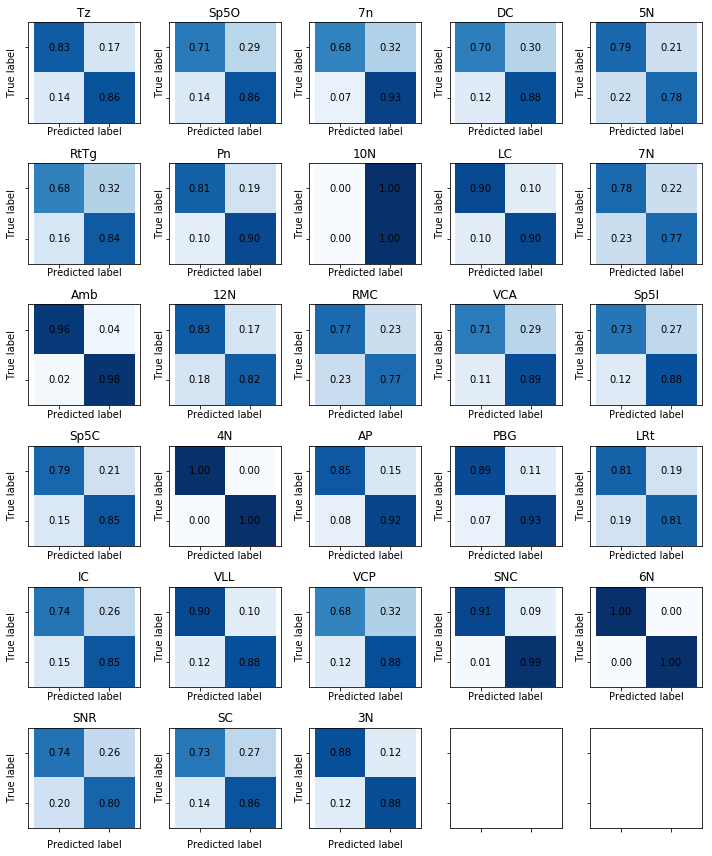

In [15]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
#     if setting in [1, 3, 4, 5, 6, 7]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
#         for surr_l in structures_found:
#             c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
#             if c in labels_found:
#                 neg_classes.append(c)
#     elif setting in [8,9,11]:
#         neg_classes = [structure + '_negative']
#     else:
#         sys.stderr.write('Setting is not recognized.\n')
#         raise

#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')
        
        
    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [16]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.862917320693


In [ ]:
# Visualize training patches

patches = extract_patches_given_locations_multiple_sections(training_addresses['12N'][:10], 
                                                            location_or_grid_index='grid_index',
                                                            version='compressed')
display_images_in_grids(patches, nc=10)

# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N_surround'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
# display_images_in_grids(patches, nc=10)

In [34]:
def patch_boxes_overlay_on(bg, downscale_factor, locs, patch_size, colors=None, stack=None, sec=None):
    """
    Assume bg has the specified downscale_factor.
    """

    if bg == 'original':
        bg = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='compressed'))[::downscale_factor, ::downscale_factor]
       
    # viz = bg.copy()
    viz = gray2rgb(bg).copy()
    # need copy() because of this bug http://stackoverflow.com/a/31316516
    
    half_size = patch_size/2/downscale_factor
    if isinstance(locs[0], list):
        if colors is None:
            colors = random_colors(len(locs))
        for i, locs_oneColor in enumerate(locs):
            for x, y in locs_oneColor:
                x = x / downscale_factor
                y = y / downscale_factor
                cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors[i], 2)
    else:
        if colors is None:
            colors = (255,0,0)
        for x, y in locs:
            x = x / downscale_factor
            y = y / downscale_factor
            cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors, 2)
            
    return viz

In [35]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

/shared/MouseBrainAtlas/learning/tmp.jpg